In [1]:
import torch.nn as nn
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
import mlflow # mlflow 사용을 위해
import warnings

/home/khkim/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model 정의

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784,100) # 28*28
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100,100)
        self.fc3 = nn.Linear(100,10)
    def forward(self, x):
        x1 = self.fc1(x)
        x2 = self.relu(x1)
        x3 = self.fc2(x2)
        x4 = self.relu(x3)
        x5 = self.fc3(x4)

        return x5

In [3]:
Net()

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

# Dataset 정의  
## MNIST Dataset을 사용하여 학습,검증을 합니다.

In [4]:
download_root = 'MNIST_data/'

train_dataset = datasets.MNIST(root=download_root,
                         train=True,
                         transform = transforms.ToTensor(),
                         download=True)
                         
test_dataset = datasets.MNIST(root=download_root,
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)    

# Batch_size, Train, Test Dataloader 정의

In [5]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 학습률, Optimizer 정의

In [6]:
model = Net()
model.zero_grad()
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Seed 고정


In [7]:
import torch.backends.cudnn as cudnn
import random
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(seed)

# MLflow를 활용하여 학습진행

In [8]:
warnings.filterwarnings(action='ignore')
experiment_name = 'chaos_AIP' # 실험명, 실험관리를 용이하게 해줍니다. 


if not mlflow.get_experiment_by_name(experiment_name): 
  mlflow.create_experiment(name=experiment_name)
experiment = mlflow.get_experiment_by_name(experiment_name)

mlflow.set_tracking_uri('http://127.0.0.1:5000') # 로컬 서버에 실행을 기록하기 위해 함수 호출

train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

total_batch = len(train_loader)
epochs = 20


best_accuracy = 0
with mlflow.start_run(experiment_id=experiment.experiment_id,run_name="boom"):
  for epoch in range(epochs):
      cost=0
      model.train()
      train_accuracy = 0
      train_loss = 0
      for images, labels in train_loader:
          images = images.reshape(100,784)
          
          optimizer.zero_grad() # 변화도 매개변수 0
          
          #forward
          #pred = model.forward(images)
          #loss = loss_function(pred, labels)
          pred = model(images)
          loss = loss_function(pred,labels)
          prediction = torch.argmax(pred,1)
          correct = (prediction == labels)
          train_accuracy += correct.sum().item() / 60000
          train_loss += loss.item() / 600
          
          #backward
          loss.backward()
          
          #Update
          optimizer.step()
          
          cost += loss
      
      with torch.no_grad(): #미분하지 않겠다는 것
          total = 0
          correct=0
          for images, labels in test_loader:
              images = images.reshape(100,784)

              outputs = model(images)
              _,predict = torch.max(outputs.data, 1)

              total += labels.size(0)
              correct += (predict==labels).sum() # 예측한 값과 일치한 값의 합

      avg_cost = cost / total_batch
      accuracy = 100*correct/total
      
      val_loss_list.append(avg_cost.detach().numpy())
      val_acc_list.append(accuracy)

      if accuracy > best_accuracy:
        torch.save(model.state_dict(),'model.pt')
        mlflow.pytorch.log_model(model,'model')
        best_accuracy = accuracy
        print(f"Save Model(Epoch: {epoch+1}, Accuracy: {best_accuracy:.5})")
      
      print("epoch : {} | loss : {:.6f}" .format(epoch+1, avg_cost))
      print("Accuracy : {:.2f}".format(100*correct/total))
      mlflow.log_param('learning-rate',learning_rate) # mlflow.log_param 을 사용하여 MLflow에 파라미터들을 기록할 수 있습니다.
      mlflow.log_param('epoch',epochs)
      mlflow.log_param('batch_size',batch_size)
      mlflow.log_param('seed',seed)
      mlflow.log_param('optimizer',optimizer)
      mlflow.log_metric('train_accuracy',train_accuracy) # mlflow.log_metric을 사용하여 MLflow에 성능평가를 위한 metric을 기록할 수 있습니다.
      mlflow.log_metric('train_loss',train_loss)
      mlflow.log_metric('valid_accuracy',accuracy)
      mlflow.log_metric('valid_loss',avg_cost)
      print("------")
mlflow.end_run()

Save Model(Epoch: 1, Accuracy: 93.95)
epoch : 1 | loss : 0.399721
Accuracy : 93.95
------
Save Model(Epoch: 2, Accuracy: 95.77)
epoch : 2 | loss : 0.171934
Accuracy : 95.77
------
Save Model(Epoch: 3, Accuracy: 96.46)
epoch : 3 | loss : 0.119864
Accuracy : 96.46
------
Save Model(Epoch: 4, Accuracy: 97.11)
epoch : 4 | loss : 0.091799
Accuracy : 97.11
------
epoch : 5 | loss : 0.073585
Accuracy : 97.05
------
Save Model(Epoch: 6, Accuracy: 97.44)
epoch : 6 | loss : 0.059317
Accuracy : 97.44
------
epoch : 7 | loss : 0.049440
Accuracy : 97.25
------
Save Model(Epoch: 8, Accuracy: 97.51)
epoch : 8 | loss : 0.040728
Accuracy : 97.51
------
epoch : 9 | loss : 0.035901
Accuracy : 97.25
------
Save Model(Epoch: 10, Accuracy: 97.58)
epoch : 10 | loss : 0.032048
Accuracy : 97.58
------
epoch : 11 | loss : 0.024930
Accuracy : 97.49
------
Save Model(Epoch: 12, Accuracy: 97.88)
epoch : 12 | loss : 0.021489
Accuracy : 97.88
------
epoch : 13 | loss : 0.019486
Accuracy : 97.60
------
epoch : 14 | l

In [9]:
import os
import json
import bentoml
import numpy as np
import pandas as pd
from torch import cuda

In [10]:
MLFLOW_PATH = './model_mlflow'

if not os.path.isdir(MLFLOW_PATH):
  mlflow.pytorch.save_model(model, MLFLOW_PATH) # mlflow 모델 로컬 디렉토리에 저장

bentoml.mlflow.import_model("mnist_clf", model_uri='./model_mlflow') # mlflow로 저장한 모델을 bentoml format에 맞추어 가져옴

Model(tag="mnist_clf:evxuymc3as3donlu", path="/home/khkim/bentoml/models/mnist_clf/evxuymc3as3donlu/")

In [11]:
!bentoml models list mnist_clf # 현재 등록되어 있는 모델 리스트 출력

 Tag                         Module          Size        Creation Time       
 mnist_clf:evxuymc3as3donlu  bentoml.mlflow  355.39 KiB  2022-11-03 08:14:48 
 mnist_clf:mna6lfs2q2mr67oi  bentoml.mlflow  355.39 KiB  2022-11-02 17:14:35 
 mnist_clf:jisf22c2qkh6f2kn  bentoml.mlflow  355.39 KiB  2022-11-02 16:45:15 
 mnist_clf:bohyihc2qch6f2kn  bentoml.mlflow  355.39 KiB  2022-11-02 16:29:11 
 mnist_clf:y7m546s2noh6f2kn  bentoml.mlflow  355.39 KiB  2022-11-02 14:04:07 
 mnist_clf:pycdv6sy3wh6f2kn  bentoml.mlflow  355.39 KiB  2022-10-31 14:33:04 
 mnist_clf:klquv2syykh6f2kn  bentoml.mlflow  355.39 KiB  2022-10-31 11:18:35 
 mnist_clf:xkvy4zsyygh6f2kn  bentoml.mlflow  355.39 KiB  2022-10-31 11:14:20 
 mnist_clf:v65qkwsyych6f2kn  bentoml.mlflow  355.39 KiB  2022-10-31 11:06:52 


In [23]:
# mnist 테스트 데이터 가져오기
with open('./test_input.json', 'r') as f:
  test_input_arr = np.array(json.load(f), dtype=np.float32)

test_input_arr[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

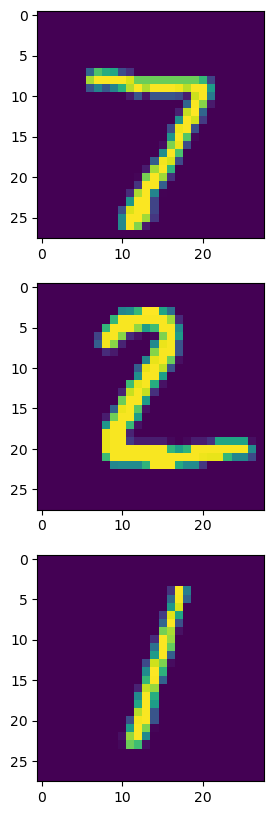

In [13]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(len(test_input_arr),1,figsize=(10,10))
for i in range(len(test_input_arr)):
    img = test_input_arr[i]
    img = img.reshape(28,28,1)
    axes[i].imshow(img)

plt.show()
    

In [14]:
# API 테스트
runner = bentoml.mlflow.get("mnist_clf:latest").to_runner()
runner.init_local()
result = runner.predict.run(test_input_arr)

for i in result:
    print(np.argmax(i))

'Runner.init_local' is for debugging and testing only.


7
2
1


In [ ]:
!bentoml serve service:svc --reload

2022-10-31T11:18:42+0900 [INFO] [cli] Prometheus metrics for HTTP BentoServer from "service:svc" can be accessed at http://localhost:3000/metrics.
2022-10-31T11:18:43+0900 [INFO] [cli] Starting development HTTP BentoServer from "service:svc" running on http://0.0.0.0:3000 (Press CTRL+C to quit)
2022-10-31 11:18:44 circus[2119121] [INFO] Loading the plugin...
2022-10-31 11:18:44 circus[2119121] [INFO] Endpoint: 'tcp://127.0.0.1:36727'
2022-10-31 11:18:44 circus[2119121] [INFO] Pub/sub: 'tcp://127.0.0.1:39683'
2022-10-31T11:18:44+0900 [INFO] [observer] Watching directories: ['/home/khkim/aip/AIP', '/home/khkim/bentoml/models']
^C
